In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, labels_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        with open(os.path.join(img_dir, labels_file), 'r') as f:
            lines = f.read().splitlines()
        self.samples = [line.split(',') for line in lines]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_name, label = self.samples[idx]
        img_path = os.path.join(self.img_dir, img_name + ".png")
        image = Image.open(img_path).convert("RGB")  # Ensures color
        label = int(label)
        if self.transform:
            image = self.transform(image)
        return image, label

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # VGG16 specific
                         std=[0.229, 0.224, 0.225])
])

In [7]:
dataset = CustomImageDataset("2025S_imgs", "labels.txt", transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

In [8]:
train_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
model = models.vgg16(pretrained=True)
for param in model.features.parameters():
    param.requires_grad = False  # Freeze conv layers

model.classifier[6] = nn.Linear(4096, 6)  # 6 classes (0 to 5)
model = model.to(device)

/Users/marilyn/anaconda3/envs/cs7785-l1/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/marilyn/anaconda3/envs/cs7785-l1/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/marilyn/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100.0%


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4)

In [12]:
epochs = 5  # You can increase this
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/5, Loss: 1.2368
Epoch 2/5, Loss: 0.3633
Epoch 3/5, Loss: 0.1253
Epoch 4/5, Loss: 0.0492
Epoch 5/5, Loss: 0.0198


In [13]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

In [14]:
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
accuracy = (all_preds == all_labels).sum() / len(all_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 93.86%


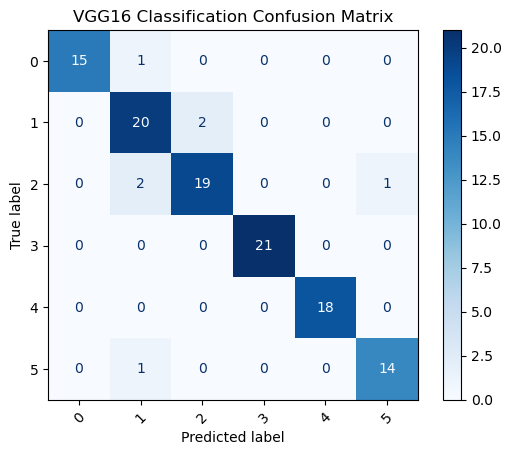

In [15]:
# ----- Step 7: Confusion Matrix -----
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(6)))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("VGG16 Classification Confusion Matrix")
plt.show()